# Lab 3: Inverse dynamics control

<div style="color: red;">

Pendientes lab3:

1. tbd
    
</div>

In [2]:
7.25+3.50+2.60+3.00+1.90+5+0.90+4.50
31.05-28.65

2.400000000000002

# Simulate the robot dynamics

## Questions

### Question 3.1: Gravity compensation

- What is the behavior of the robot when you apply virtual forces to the EE? Use videos and/or plots to support your answer.

### Answer 3.1

1. El sistema equivale a un doble integrador, que es críticamente inestable, así que cualquier perturbación lo desestabiliza

In [1]:
%%html
<video width="640" height="360" controls>
  <source src="control_compensar_gravedad.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

2. Diseñamos el sistema equivalente en Matlab para evaluar su comportamiento:

![Gravity BA](lab3gravityBA.jpg)

3. Cuando no hay fuerzas externas el sistema se mantiene constante, pero al añadir una fuerza a alguna articulación (escalón que empieza en t=2 segundos) el sistema se desestabiliza y tarda casi un minuto en volver al equilibrio:

![Gravity BA](lab3gravityBAstep.jpg)

4. Para estabilizar el sistema, podemos añadir un controlador PD en un bucle cerrado (ver pág 20 del tema):


![Gravity BC](lab3gravityBC.jpg)

5. En este caso el tiempo para estabilizar el sistema se reduce drásticamente:

![Gravity BC](lab3gravityBCstep.jpg)


### Question 3.2: Linearization by inverse dynamics control

- What happens if the compensation dynamics model is not exactly the same as the manipulator dynamics?
   1. Try to change the masses m1, m2 and lengths l1, l2 of the links in the dynamics_params.yaml (gravity_compensation) file. What are the effects of having incorrent dynamics parameters when launching the gravity compensation controller?
   2. Try the same for the dynamics cancellation. In this case, you can also change the parameters b1 and b2. What are the effects when launching the dynamics cancellation controller?

- What is the behavior of the robot under the inverse dynamics controller when you apply virtual forces to the EE? Use videos and/or plots to support your answer.

### Answer 3.2a

1. En el caso de la compensación de gravedad, si se cambia cualquiera de los parámetros que dependen de la matriz de inercia M (m1, m2, l1, l2), el compensador genera una fuerza distinta de la que ejerce la gravedad, y el sistema se desestabiliza completamente. Por ejemplo, cambiando 10 gramos en la masa de m1:

```yaml
uma_arm_dynamics:
  ros__parameters:
    frequency: 1000.0
    m1: 2.99
    m2: 2.0
    l1: 1.0
    l2: 0.6
    b1: 5.0
    b2: 5.0
    g: 9.81
    q0: [0.785398, -0.785398]
```
El sistema se mueve inicialmente muy despacio pero paulatinamente adquiere velocidad

2. En el caso de la compensación dinámica, pasa lo mismo si se cambia cualquier parámetro de la matriz de inercia (el sistema se vuelve inestable). Sin embargo, al cambiar la viscosidad (que no interviene en la matriz de inercia), la compensación que hace falta para equilibrar el sistema se calcula inicialmente mal, pero a medida que el brazo cambia de posición la fuerza que ejerce el compensador acaba equiparándose a la fuerza que ejerce la gravedad y el sistema se estabiliza y el manipulador se detiene.

Cambiando b1=b2=8 el resultado sería el siguiente

In [1]:
%%html
<video width="640" height="360" controls>
  <source src="control_dinámico_b1_b2_8.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

### Asnwer 3.b

En el caso de aplicar fuerzas externas, el sistema pierde su estabilidad como se aprecia en el video siguiente. Para estabilizar el sistema habría que añadir un controlador PD que, a partir de las consignas $\ddot q_d$, $\dot q_d$, $q_d$ deseadas, calcule los errores en posición y en velocidad y añada ajustes para dichos errores a la consigna de aceleración $\ddot q_d$:



In [2]:
%%html
<video width="640" height="360" controls>
  <source src="control_dinámico_fuerzas_ext.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

## Gravity compensation

```C++
    // Method to calculate the desired joint torques
    Eigen::VectorXd gravity_compensation()
    {
        // Placeholder for calculate the commanded torques
        // Calculate the control torque to compensate only for gravity effects: 
        //    tau = g(q)

        // Initialize q1, q2, q_dot1, and q_dot2
        double q1 = joint_positions_(0);
        double q2 = joint_positions_(1);

        // Calculate g_vect
        Eigen::VectorXd g_vec(2);   // gravity vector        
        g_vec << (m1_ + m2_)*l1_*g_*cos(q1) + m2_*g_*l2_*cos(q1 + q2),
                  m2_       *l2_*g_*cos(q1+q2);

        // // Calculate desired torque
        Eigen::VectorXd torque(2);
        torque << g_vec;

        return torque; // joint_torques_ = gravity_compensation();
    }
```

## Linearization by inverse dynamics control

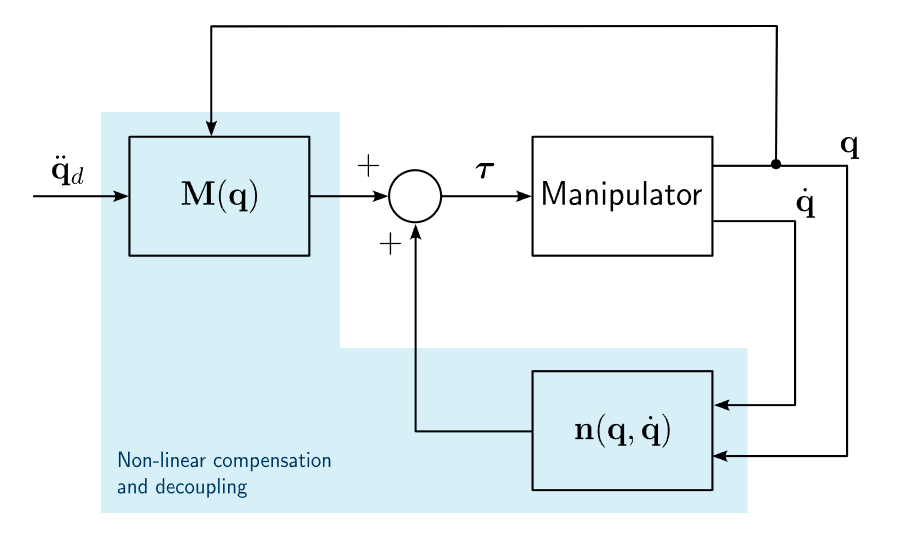


```C++
// Method to calculate joint acceleration
        Eigen::VectorXd cancel_dynamics()
        {
            // Initialize M, C, Fb, g_vec, and tau_ext
            Eigen::MatrixXd M(2, 2);    // Inertia matrix
            Eigen::VectorXd Cq_dot(2);  // Coriolis and centrifugal forces matrix
            Eigen::MatrixXd Fb(2, 2);   // Viscous friction matrix
            Eigen::VectorXd g_vec(2);   // gravity vector
            
            // Initialize q1, q2, q_dot1, and q_dot2?
            double q1 = joint_positions_(0);
            double q2 = joint_positions_(1);
            double q_dot1 = joint_velocities_(0);
            double q_dot2 = joint_velocities_(1);


            // Calculate matrix M
            M(0, 0) = m1_*pow(l1_, 2) + m2_*(pow(l1_, 2) + 2*l1_*l2_*cos(q2) + pow(l2_, 2));
            M(0, 1) = m2_*(l1_*l2_*cos(q2) + pow(l2_, 2));
            M(1, 0) = M(0, 1);
            M(1, 1) = m2_*pow(l2_, 2);

            // Calculate vector C (C is 2x1 because it already includes q_dot)
            Cq_dot << -m2_*l1_*l2_*sin(q2)*(2*q_dot1*q_dot2 + pow(q_dot2, 2)),
                       m2_*l1_*l2_*pow(q_dot1, 2)*sin(q2);

            // Calculate Fb matrix
            Fb << b1_, 0.0,
                  0.0, b2_;

            // Calculate g_vect
            g_vec << (m1_ + m2_)*l1_*g_*cos(q1) + m2_*g_*l2_*cos(q1 + q2),
                        m2_     *l2_*g_*cos(q1+q2);

            // Calculate control torque using the dynamic model:             
            // torque = M * q_ddot + C * q_dot + Fb * q_dot + g
            Eigen::VectorXd torque(2);
            torque << M*desired_joint_accelerations_ +  // M(q)
                      Cq_dot + Fb*joint_velocities_ + g_vec; // n(q, qdot)

            return torque; // joint_torques_ = cancel_dynamics()
        }
```